In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Squeeze and Excitation
class mySELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(mySELayer, self ).__init__()
        self .avg_pool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False)#,
            #nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        y = torch.clamp(y, 0, 1)
        return x * F.relu6(y + 3.) / 6. #y.expand_as(x)

# Ghost Module
class myGhostModule(nn.Module):
    def __init__(self, inp, out, kernel_size=1, relu=True):
        super(myGhostModule, self).__init__()
        self.out = out
        init_channels = int(math.ceil(out/2))

        self.primary_conv = nn.Sequential(
            nn.Conv2d(inp, init_channels, kernel_size=(1,1), stride=(1,1), bias=False),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True) if relu else nn.Sequential()
        )

        self.cheap_operation = nn.Sequential(
            nn.Conv2d(init_channels, init_channels, kernel_size=(3,3), stride=(1,1), padding=(1,1), groups=init_channels, bias=False),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True) if relu else nn.Sequential()
        )

    def forward(self, x):
        x1 = self.primary_conv(x)
        x2 = self.cheap_operation(x1)
        out = torch.cat([x1,x2], dim=1)
        return out[:,:self.out,:,:]

# Depthwise
def myDWConv(inp, out, kernel_size=3, stride=1, relu=False):
    return nn.Sequential(
        nn.Conv2d(inp, out, kernel_size, stride, kernel_size//2, groups=inp, bias=False),
        nn.BatchNorm2d(out),
        nn.ReLU(inplace=True) if relu else nn.Sequential()
    )

# Ghost Bottleneck
class myGhostBottleneck(nn.Module):
    def __init__(self, inp, exp, out, kernel_size, stride, use_se):
        super(myGhostBottleneck, self).__init__()

        self.conv = nn.Sequential(
            # Ghost module 1
            myGhostModule(inp, exp, kernel_size=1, relu=True),
            # Depthwise convolution
            myDWConv(exp, exp, kernel_size, stride, relu=False) if stride==2 else nn.Sequential(),
            # Squeeze and Excite
            mySELayer(exp) if use_se else nn.Sequential(),
            # Ghost module 2
            myGhostModule(exp, out, kernel_size=1, relu=False),
        )
        # Shortcut
        if stride==1 and inp == out:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                myDWConv(inp, inp, kernel_size, stride, relu=True),
                nn.Conv2d(inp, out, 1, 1, 0, bias=False),
                nn.BatchNorm2d(out)
            )

    def forward(self, x):
      return self.conv(x) + self.shortcut(x)

# GhostNet
class myGhostNet(nn.Module):
    def __init__(self):
        super(myGhostNet, self).__init__()

        # First Convolution
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=(2,2), padding=(1,1), bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(inplace=True)
        )
        # Block 1
        self.layer11 = myGhostBottleneck(inp=16, exp=16, out=16, kernel_size=3, stride=1, use_se=False)
        self.layer12 = myGhostBottleneck(16, 48, 24, 3, 2, False)
        # Block 2
        self.layer21 = myGhostBottleneck(24, 72, 24, 3, 1, False)
        self.layer22 = myGhostBottleneck(24, 72, 40, 3, 2, True)
        # Block 3
        self.layer31 = myGhostBottleneck(40, 120, 40, 3, 1, True)
        self.layer32 = myGhostBottleneck(40, 240, 80, 5, 2, False)
        # Block 4
        self.layer41 = myGhostBottleneck(80, 200, 80, 3, 1, False)
        self.layer42 = myGhostBottleneck(80, 184, 80, 3, 1, False)
        self.layer43 = myGhostBottleneck(80, 184, 80, 3, 1, False)
        self.layer44 = myGhostBottleneck(80, 480, 112, 3, 1, True)
        self.layer45 = myGhostBottleneck(112, 672, 112, 3, 1, True)
        self.layer46 = myGhostBottleneck(112, 672, 160, 3, 2, True)
        # Block 5
        self.layer51 = myGhostBottleneck(160, 960, 160, 5, 1, False)
        self.layer52 = myGhostBottleneck(160, 960, 160, 5, 1, True)
        self.layer53 = myGhostBottleneck(160, 960, 160, 5, 1, False)
        self.layer54 = myGhostBottleneck(160, 960, 160, 5, 1, True)
        self.layer55 = nn.Sequential(
            nn.Conv2d(160, 960, kernel_size=(1,1), stride=(1,1), bias=False),
            nn.BatchNorm2d(960),
            nn.ReLU(inplace=True)
        )
        # AVGPool
        self.AVGPool = nn.AdaptiveAvgPool2d((1,1))
        # Conv
        self.ConvLast = nn.Sequential(
            nn.Conv2d(960, 1280, kernel_size=(1,1), stride=(1,1)),
            nn.ReLU(inplace=True)
        )
        # Fully Connected
        # self.fc = nn.Linear(1280, 1000)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1280, 3),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer21(x)
        x = self.layer22(x)
        x = self.layer31(x)
        x = self.layer32(x)
        x = self.layer41(x)
        x = self.layer42(x)
        x = self.layer43(x)
        x = self.layer44(x)
        x = self.layer45(x)
        x = self.layer46(x)
        x = self.layer51(x)
        x = self.layer52(x)
        x = self.layer53(x)
        x = self.layer54(x)
        x = self.layer55(x)
        x = self.AVGPool(x)
        x = self.ConvLast(x)
        # x = self.fc(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


model = myGhostNet()
# model.eval()
# print(model)
# print("||-------------------------------------------------------------------||")
# input = torch.randn(32, 3, 224, 224)
# y = model(input)
# # print(y)
# from torchsummary import summary
# summary(model, (3, 224, 224))

## Download data

In [2]:
pip install openimages focal_loss_torch

     |████████████████████████████████| 133kB 15.1MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 81kB 8.3MB/s 
     |████████████████████████████████| 7.5MB 18.8MB/s 
     |████████████████████████████████| 296kB 58.4MB/s 
     |████████████████████████████████| 144.2MB 99kB/s 
ERROR: botocore 1.20.62 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [3]:
import os
from openimages.download import download_dataset

In [4]:
data_dir = "data"
number_for_samples = 300
classes = ["Tie", "Door", "Laptop"]

In [5]:
## rm -r data test_dir

In [6]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [7]:
print("Downloading is starting...")
download_dataset(data_dir, classes, limit=number_for_samples)

2021-05-01  21:42:14 INFO NumExpr defaulting to 2 threads.
2021-05-01  21:42:17 INFO Downloading 300 train images for class 'tie'
100%|██████████| 300/300 [00:07<00:00, 37.80it/s]
2021-05-01  21:42:25 INFO Downloading 300 train images for class 'door'
100%|██████████| 300/300 [00:08<00:00, 37.14it/s]
2021-05-01  21:42:33 INFO Downloading 300 train images for class 'laptop'
100%|██████████| 300/300 [00:07<00:00, 38.37it/s]


{'door': {'images_dir': 'data/door/images'},
 'laptop': {'images_dir': 'data/laptop/images'},
 'tie': {'images_dir': 'data/tie/images'}}

## Data preparation, loading needed functions

In [8]:
from torch.autograd import Variable

import torchvision
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt

writer = SummaryWriter() 

In [9]:
# check the GPU
!nvidia-smi

Sat May  1 21:42:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
model.cuda()
model

myGhostNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer11): myGhostBottleneck(
    (conv): Sequential(
      (0): myGhostModule(
        (primary_conv): Sequential(
          (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (cheap_operation): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): Sequential()
      (2): Sequential()
      (3): myGhostModule(
        (primary_conv): Sequential(
          (0): Conv2d(16, 8, k

In [11]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
# from torch.utils.data import Dataset
import numpy as np
# from skimage import io
# from skimage.transform import resize
# import glob
import PIL

In [12]:
scaler = transforms.Scale((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

In [13]:
def read_img(file_name):
    img = Image.open(file_name)
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    return t_img.float()

In [14]:
transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
   # torchvision.transforms.RandomHorizontalFlip(),
   # torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor()
])

In [15]:
dataset = datasets.ImageFolder("data/", transform = transform)
dataset.imgs

[('data/door/images/00005bf623ff1ac2.jpg', 0),
 ('data/door/images/0001cd31df1c25c6.jpg', 0),
 ('data/door/images/0001d48938a45d49.jpg', 0),
 ('data/door/images/00033546c87cf14a.jpg', 0),
 ('data/door/images/000452412ea32b9b.jpg', 0),
 ('data/door/images/000477fbd201b1ff.jpg', 0),
 ('data/door/images/000497c81f04d99d.jpg', 0),
 ('data/door/images/0004f9215c25b291.jpg', 0),
 ('data/door/images/00055fbe66da40b7.jpg', 0),
 ('data/door/images/00056c76aa3dd52a.jpg', 0),
 ('data/door/images/0005a348c681e8af.jpg', 0),
 ('data/door/images/0005bba99e7b35e0.jpg', 0),
 ('data/door/images/000644de8101e08d.jpg', 0),
 ('data/door/images/00066af7b52f505c.jpg', 0),
 ('data/door/images/000692d348b0f181.jpg', 0),
 ('data/door/images/000705beb2c713fd.jpg', 0),
 ('data/door/images/0008f5ea794738b6.jpg', 0),
 ('data/door/images/000990a927deb20e.jpg', 0),
 ('data/door/images/0009c4ddcaab18d3.jpg', 0),
 ('data/door/images/000a033f5e356e88.jpg', 0),
 ('data/door/images/000a05dd07294ce4.jpg', 0),
 ('data/door/

In [16]:
train_dataset = torch.utils.data.DataLoader(dataset, batch_size=15, shuffle=True)

torch.Size([224, 224, 3])


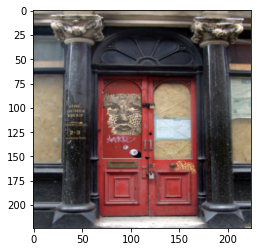

In [17]:
images, labels = next(iter(train_dataset))
im = images.permute(0, 2, 3, 1)
print(im[0].shape)
plt.imshow(im[0])

In [18]:
for images, labels in iter(train_dataset):
    print(images.shape, labels)

torch.Size([15, 3, 224, 224]) tensor([2, 0, 1, 1, 1, 0, 0, 2, 2, 1, 0, 1, 1, 2, 2])
torch.Size([15, 3, 224, 224]) tensor([2, 0, 2, 1, 2, 1, 1, 0, 0, 2, 0, 1, 1, 2, 1])
torch.Size([15, 3, 224, 224]) tensor([1, 0, 1, 0, 0, 1, 2, 0, 0, 2, 2, 2, 0, 0, 0])
torch.Size([15, 3, 224, 224]) tensor([1, 1, 0, 2, 0, 2, 2, 1, 0, 2, 0, 1, 0, 1, 2])
torch.Size([15, 3, 224, 224]) tensor([0, 2, 2, 0, 0, 1, 0, 2, 2, 2, 1, 2, 0, 0, 0])
torch.Size([15, 3, 224, 224]) tensor([1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 2, 0, 0])
torch.Size([15, 3, 224, 224]) tensor([1, 1, 1, 2, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2])
torch.Size([15, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 2, 1, 2, 0, 2, 1, 2, 2, 0, 1])
torch.Size([15, 3, 224, 224]) tensor([1, 0, 0, 0, 1, 2, 0, 1, 1, 0, 2, 1, 1, 1, 2])
torch.Size([15, 3, 224, 224]) tensor([0, 1, 1, 2, 1, 0, 1, 1, 0, 2, 2, 0, 0, 2, 2])
torch.Size([15, 3, 224, 224]) tensor([2, 2, 0, 0, 0, 1, 1, 2, 1, 2, 0, 2, 0, 0, 0])
torch.Size([15, 3, 224, 224]) tensor([0, 2, 1, 1, 1, 1, 0, 1, 2, 1, 2, 2, 1,

In [19]:
def batch_to_one_hot(id, batch_size, nb_classes = 2):
    y_onehot = torch.FloatTensor(batch_size, nb_classes)
    y_onehot.zero_()
    y_onehot.scatter_(1, id.view(-1, 1), 1)
    return y_onehot.long()

## Model training

In [20]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss().cuda() 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
# number of epochs to train the model
n_epochs = 50

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    validation_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for images, labels in iter(train_dataset):
        
        # _ stands in for labels, here
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images.cuda())
        
        # calculate the loss
        labels = labels.long() # torch.tensor(labels, dtype=torch.long)
        yLabels = batch_to_one_hot(labels, images.shape[0], 3)

        loss = criterion(outputs, labels.cuda())
       
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
        
        writer.add_scalar('ConvLoss/train', train_loss / len(train_dataset), epoch)
        

    # print avg training statistics 
    train_loss = train_loss / len(train_dataset)
    print('Epoch: {} \tTraining Loss: {:.10f}'.format(
        epoch, 
        train_loss 
        ))

Epoch: 1 	Training Loss: 16.5249447525
Epoch: 2 	Training Loss: 16.4980515838
Epoch: 3 	Training Loss: 16.4762613177
Epoch: 4 	Training Loss: 16.4350500703
Epoch: 5 	Training Loss: 16.4740762413
Epoch: 6 	Training Loss: 16.4429839849
Epoch: 7 	Training Loss: 16.4108981192
Epoch: 8 	Training Loss: 16.3896316886
Epoch: 9 	Training Loss: 16.3568665981
Epoch: 10 	Training Loss: 16.3274706900
Epoch: 11 	Training Loss: 16.2595795095
Epoch: 12 	Training Loss: 16.1787284017
Epoch: 13 	Training Loss: 15.9125444144
Epoch: 14 	Training Loss: 15.6868618727
Epoch: 15 	Training Loss: 15.2800185233
Epoch: 16 	Training Loss: 14.8650101423
Epoch: 17 	Training Loss: 14.3976102620
Epoch: 18 	Training Loss: 13.9586245269
Epoch: 19 	Training Loss: 13.6388570517
Epoch: 20 	Training Loss: 13.3079989403


In [22]:
outputs, labels

(tensor([[0.0911, 0.2767, 0.6322],
         [0.0116, 0.0907, 0.8977],
         [0.1314, 0.1199, 0.7487],
         [0.2754, 0.7102, 0.0144],
         [0.0722, 0.5790, 0.3488],
         [0.1166, 0.8004, 0.0831],
         [0.0050, 0.1011, 0.8939],
         [0.5408, 0.2765, 0.1827],
         [0.0103, 0.6974, 0.2923],
         [0.0567, 0.4623, 0.4810],
         [0.0404, 0.5585, 0.4012],
         [0.9531, 0.0295, 0.0174],
         [0.9755, 0.0155, 0.0090],
         [0.0068, 0.1427, 0.8505],
         [0.9254, 0.0343, 0.0403]], device='cuda:0', grad_fn=<SoftmaxBackward>),
 tensor([2, 1, 2, 1, 1, 1, 2, 0, 2, 1, 1, 0, 1, 1, 0]))

In [23]:
np.round(outputs.cpu().detach().numpy(), 5)

array([[0.09105, 0.27674, 0.6322 ],
       [0.0116 , 0.09068, 0.89772],
       [0.13135, 0.1199 , 0.74875],
       [0.27539, 0.71025, 0.01437],
       [0.07219, 0.57899, 0.34882],
       [0.11656, 0.80037, 0.08306],
       [0.005  , 0.10113, 0.89387],
       [0.5408 , 0.27652, 0.18268],
       [0.01026, 0.69743, 0.29231],
       [0.05672, 0.46227, 0.48101],
       [0.04036, 0.55845, 0.40119],
       [0.95306, 0.02954, 0.0174 ],
       [0.97553, 0.01549, 0.00897],
       [0.0068 , 0.14265, 0.85055],
       [0.9254 , 0.03432, 0.04028]], dtype=float32)

In [24]:
data_dir = "test_dir"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [25]:
number_for_samples = 100 
print("Downloading is starting...")
download_dataset(data_dir, classes, limit=number_for_samples)

2021-05-01  21:49:33 INFO Downloading 100 train images for class 'tie'
100%|██████████| 100/100 [00:03<00:00, 30.79it/s]
2021-05-01  21:49:36 INFO Downloading 100 train images for class 'door'
100%|██████████| 100/100 [00:03<00:00, 30.94it/s]
2021-05-01  21:49:39 INFO Downloading 100 train images for class 'laptop'
100%|██████████| 100/100 [00:03<00:00, 31.58it/s]


{'door': {'images_dir': 'test_dir/door/images'},
 'laptop': {'images_dir': 'test_dir/laptop/images'},
 'tie': {'images_dir': 'test_dir/tie/images'}}

In [26]:
transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [27]:
test_dataset = datasets.ImageFolder(data_dir, transform = transform)
test_dataset = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset.imgs), shuffle=True)

In [28]:
with torch.no_grad():
    model.eval()
    images, labels = next(iter(test_dataset))
    yLabels = batch_to_one_hot(labels, images.shape[0], 3)
    outputs = model(images.cuda())
    predicted_classes = torch.argmax(outputs, axis = 1).cpu()
    predicted_classes
    predicted = batch_to_one_hot(predicted_classes, outputs.shape[0], 3)
    predicted

In [29]:
yLabels.shape, outputs.shape

(torch.Size([300, 3]), torch.Size([300, 3]))

In [30]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(yLabels, predicted)

array([[[155,  45],
        [  6,  94]],

       [[191,   9],
        [ 60,  40]],

       [[165,  35],
        [ 23,  77]]])

## Example

In [31]:
# Download an example image from the pytorch website
import urllib
url, filename = ("http://farm2.staticflickr.com/1427/4723145372_21f982c03b_z.jpg", "4723145372_21f982c03b_z.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [32]:
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

In [33]:
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# # Tensor of shape 3, with confidence scores over Imagenet's 1000 classes
# print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([1.5443e-39, 1.0000e+00, 2.8974e-31], device='cuda:0')
tensor([0.2119, 0.5761, 0.2119], device='cuda:0')
